### MGT-502 Final Project

__Nadège Baertschi & Zélia Décaillet__

_May 2025_

# ReadingBuddy - Book Recommender

## Import libraries

In [ ]:
#pip install sentence-transformers gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 MB 8.3 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 11.9 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [ ]:
#pip install tf-keras

INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
  Using cached protobuf-4.25.7-cp37-abi3-macosx_10_9_universal2.whl.metadata (541 bytes)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 11.4 MB/s eta 0:00:00
Using cached protobuf-4.25.7-cp37-abi3-macosx_10_9_universal2.whl (394 kB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.4
    Uninstalling protobuf-5.29.4:
      Successfully uninstalled protobuf-5.29.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ortools 9.12.4544 requires protobuf<5.30,>=5.29.3, but you have protobuf 4.25.7 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
import os

## Import Data

In [3]:
repo_url = "https://raw.githubusercontent.com/baertsch/MGT-502-ML-Project/main/"

# Load datasets
interactions_train_df = pd.read_csv(repo_url + "kaggle_data/interactions_train.csv")
interactions_train_df.rename(columns={"u": "user_id"}, inplace=True)

#Original items.csv with a lot of missing data
items_old_df = pd.read_csv(repo_url + "kaggle_data/items.csv")

#New items.csv with less missing data
items_df = pd.read_csv(repo_url + "kaggle_data/items_df.csv")
sample_submission_df = pd.read_csv(repo_url + "kaggle_data/sample_submission.csv")

#Display
display(interactions_train_df.head())
display(items_df.head())
display(sample_submission_df.head())



,user_id,i,t
0,4456,8581,1.687541e+09
1,142,1964,1.679585e+09
2,362,3705,1.706872e+09
3,1809,11317,1.673533e+09
4,4384,1323,1.681402e+09


,Title,Author,ISBN Valid,Publisher,Subjects,i,Synopsis,Image
0,Classification décimale universelle : édition ...,UDC Consortium (The Hague),9782871303336; 2871303339,Ed du CEFAL,Classification décimale universelle; Indexatio...,0,NaN,https://images.isbndb.com/covers/8447463483210...
1,Les interactions dans l'enseignement des langu...,"Cicurel, Francine, 1947-",9782278058327; 2278058320,Didier,didactique--langue étrangère - enseignement; d...,1,C'est dans l'interaction en classe que s'actua...,https://images.isbndb.com/covers/2099063482999...
2,Histoire de vie et recherche biographique : pe...,"Aneta Slowik, Hervé Breton, Gaston Pineau",2343190194; 9782343190198,L'Harmattan,Histoires de vie en sociologie; Sciences socia...,2,Depuis la parution en 1918 de l'ouvrage fondat...,NaN
3,Ce livre devrait me permettre de résoudre le c...,"Mazas, Sylvain, 1980-",9782365350020; 236535002X; 9782365350488; 2365...,Vraoum!,Moyen-Orient; Bandes dessinées autobiographiqu...,3,"Product DescriptionSylvain Mazas, étudiants au...",https://images.isbndb.com/covers/4356503483030...
4,Les années glorieuses : roman,"Lemaitre, Pierre, 1951-",9782702180815; 2702180817; 9782702183618; 2702...,Calmann-Lévy,France--1945-1975; Roman historique; Roman fra...,4,"Trois histoires d'amour, un lanceur d'alerte, ...",https://images.isbndb.com/covers/2369653483150...


,user_id,recommendation
0,0,3758 11248 9088 9895 5101 6074 9295 14050 1096...
1,1,3263 726 1589 14911 6432 10897 6484 7961 8249 ...
2,2,13508 9848 12244 2742 11120 2893 2461 5439 116...
3,3,2821 10734 6357 5934 2085 12608 12539 10551 10...
4,4,12425 219 11602 1487 14178 489 13888 2110 4413...


In [4]:
n_users = interactions_train_df['user_id'].nunique()
n_items = items_df['i'].nunique()
print(f"Number of users: {n_users}")
print(f"Number of books in the library: {items_df['i'].nunique()}")

Number of users: 7838
Number of books in the library: 15291


It looks like there are __7838__ users and __15291__ books in the library.

## Split the data

In [5]:
#Split the dataset based on the timestamp
interactions_train_df.sort_values(by=['user_id', 't'], inplace=True)
interactions_train_df['pct_rank'] = interactions_train_df.groupby('user_id')['t'].rank(pct=True, method='dense')
interactions_train_df.reset_index(drop=True, inplace=True)
interactions_train_df.head(10)

,user_id,i,t,pct_rank
0,0,0,1.680191e+09,0.04
1,0,1,1.680783e+09,0.08
2,0,2,1.680801e+09,0.12
3,0,3,1.683715e+09,0.16
4,0,3,1.683715e+09,0.20
5,0,4,1.686569e+09,0.24
6,0,5,1.687014e+09,0.28
7,0,6,1.687014e+09,0.32
8,0,7,1.687014e+09,0.36
9,0,8,1.687260e+09,0.40


In [6]:
train_data = interactions_train_df[interactions_train_df['pct_rank'] <= 0.8]
test_data = interactions_train_df[interactions_train_df['pct_rank'] > 0.8]
print("Training set size:", train_data.shape[0])
print("Test set size:", test_data.shape[0])

Training set size: 66577
Test set size: 20470


In [7]:
print(train_data[['user_id','i']].duplicated().sum())
print(test_data[['user_id','i']].duplicated().sum())

16055
2044


It seems that the some users have interacted with some items more than once.

## First model: Item-to-Item

We are going to build first a model which treats doesn't account for the frequency a user has interacted with an item.

### Create User-Item Matrices

In [8]:
def create_data_matrix1(data, n_users, n_items):
    """
    This function creates a data matrix with binary values for the interactions, 1 is interaction and 0 is no interaction.
    The data matrix is of shape (n_users, n_items). 
    """
    data_matrix = np.zeros((n_users, n_items))
    data_matrix[data['user_id'].values, data['i'].values] = 1
    return data_matrix

In [9]:
train_data_matrix = create_data_matrix1(train_data, n_users, n_items)
test_data_matrix = create_data_matrix1(test_data, n_users, n_items)

# Display the matrices
print("Training data matrix")
print(train_data_matrix)
print("Number of interactions: ", np.sum(train_data_matrix))
print("Testing data matrix")
print(test_data_matrix)
print("Number of interactions: ", np.sum(test_data_matrix))

Training data matrix
[[1. 1. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Number of interactions:  50522.0
Testing data matrix
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Number of interactions:  18426.0


In [10]:
# Matrix to train on full data in order to get recommendations for Kaggle
full_data_matrix = create_data_matrix1(interactions_train_df,n_users,n_items)

### Visualization of the matrices for a small portion of the data

In [11]:
def plot_interaction_heatmap1(data_matrix, n_users=50,n_items=50, title="Interaction Heatmap"):
    """
    This function plots a heatmap of the interaction data matrix.
    """
    matrix_subset = data_matrix[:n_users, :n_items]

    plt.figure(figsize=(10, 8))
    sns.heatmap(matrix_subset, cmap='YlGnBu', cbar=True,cbar_kws={'label': 'Interaction (1 = Positive, 0 = None)'})
    plt.title(title)
    plt.xlabel('Item ID')
    plt.ylabel('User ID')
    plt.show()
    

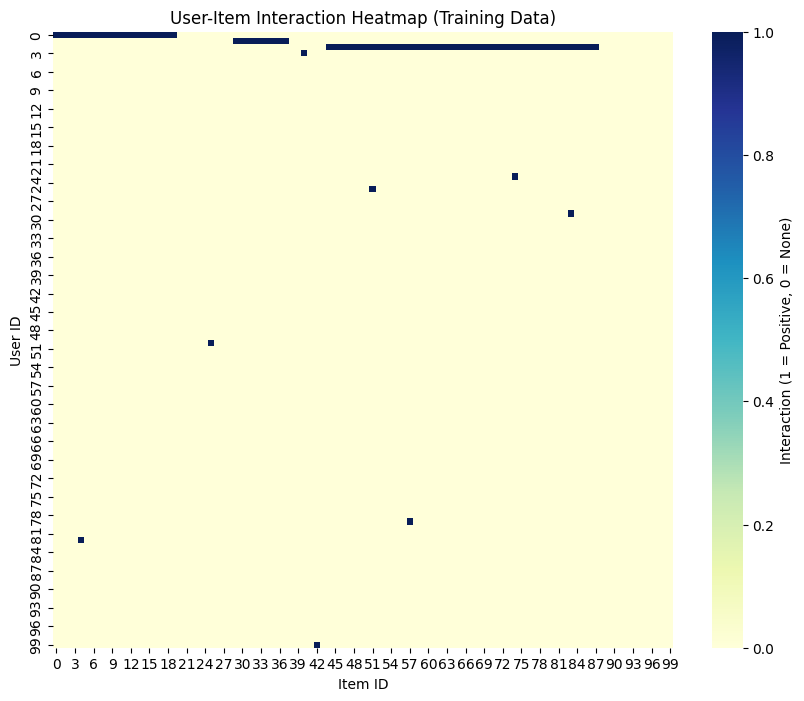

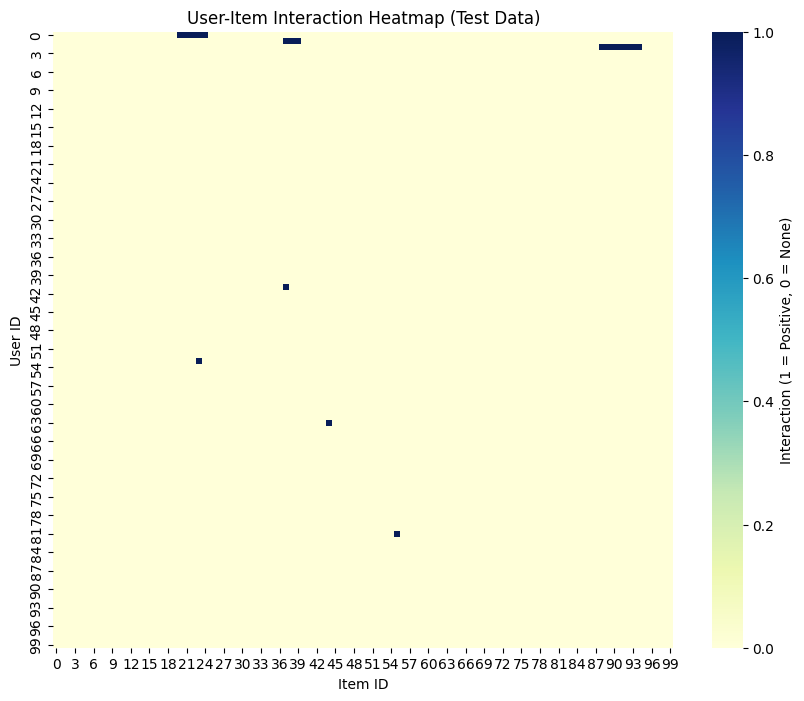

In [12]:
plot_interaction_heatmap1(train_data_matrix, n_users=100, n_items=100, title="User-Item Interaction Heatmap (Training Data)")
plot_interaction_heatmap1(test_data_matrix, n_users=100, n_items=100, title="User-Item Interaction Heatmap (Test Data)")

### Item Similarity

In [13]:
item_similarity = cosine_similarity(train_data_matrix.T)
print(item_similarity)
print("Item similarity shape:", item_similarity.shape)

[[1.         0.40824829 0.33333333 ... 0.         0.         0.        ]
 [0.40824829 1.         0.40824829 ... 0.         0.         0.        ]
 [0.33333333 0.40824829 1.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 1.         0.         0.        ]
 [0.         0.         0.         ... 0.         1.         0.        ]
 [0.         0.         0.         ... 0.         0.         1.        ]]
Item similarity shape: (15291, 15291)


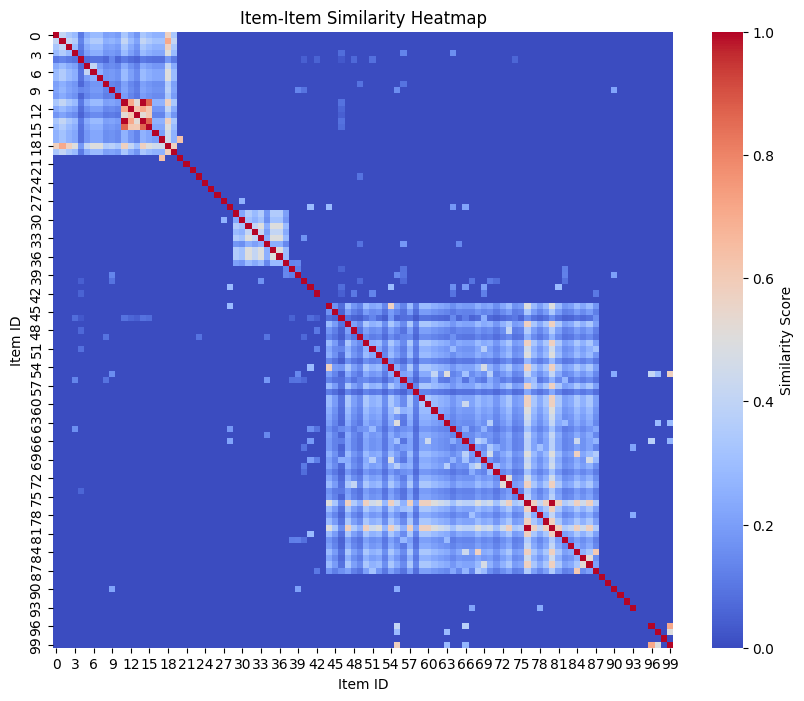

In [14]:
# Let's visualize the item similarity matrix
def plot_similarity_heatmap(matrix, n_items=50, title="Item Similarity Heatmap",x_label='X ID',y_label='y ID'):
    """
    This function plots a heatmap of the item similarity matrix.
    """
    plt.figure(figsize=(10, 8))
    sns.heatmap(matrix[:n_items, :n_items], cmap='coolwarm', cbar=True,cbar_kws={'label': 'Similarity Score'})
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()
plot_similarity_heatmap(item_similarity, n_items=100, title="Item-Item Similarity Heatmap",x_label='Item ID',y_label='Item ID')

Let's look at the clusters of high similarity 

In [15]:
items_df[(items_df['i']>=11) & (items_df['i']<=15)]

,Title,Author,ISBN Valid,Publisher,Subjects,i,Synopsis,Image
11,Rendre les élèves acteurs de leurs apprentissa...,"Béal, Yves",9782206013725; 220601372X,Delagrave,apprentissage (psychologie)--enfant; apprentis...,11,Présentation de réflexions et de remarques aut...,https://images.isbndb.com/covers/1188358348297...
12,L'apprentissage par projets au secondaire : gu...,"Larmer, John",9782765033202; 276503320X,Chenelière éducation,apprentissage (psychologie)--enseignement seco...,12,NaN,https://images.isbndb.com/covers/1300614348317...
13,Pour une pédagogie du projet,"Bordalo, Isabelle",9782011709219; 2011709210,Hachette éducation,Enseignement--Méthode des projets,13,"La demande de projet est incontournable, dans ...",https://images.isbndb.com/covers/6758033482904...
14,Une classe qui coopère : pourquoi ? comment ?,"Staquet, Christian",9782850084324; 2850084328,Chronique sociale,apprentissage (psychologie)--classe (enseignem...,14,Comment organiser les apprentissages pour que ...,https://images.isbndb.com/covers/2094366348320...
15,Penser le projet : concepts et outils d'une pé...,"Tilman, Francis",2850085510; 9782850085512,Chronique sociale,pédagogie de la maîtrise,15,La pédagogie du projet est omniprésente dans l...,NaN


In [16]:
items_df[(items_df['i']>=0) & (items_df['i']<=19)][['Title','Subjects']]

,Title,Subjects
0,Classification décimale universelle : édition ...,Classification décimale universelle; Indexatio...
1,Les interactions dans l'enseignement des langu...,didactique--langue étrangère - enseignement; d...
2,Histoire de vie et recherche biographique : pe...,Histoires de vie en sociologie; Sciences socia...
3,Ce livre devrait me permettre de résoudre le c...,Moyen-Orient; Bandes dessinées autobiographiqu...
4,Les années glorieuses : roman,France--1945-1975; Roman historique; Roman fra...
5,100 idées pour mieux gérer les troubles de l'a...,Trouble déficitaire de l'attention avec ou san...
6,La boîte à outils des formateurs : 71 outils...,Formateurs (éducation des adultes)--Formation...
7,L'autorité éducative dans la classe : douze si...,autorité--relation maître-élève; autorité--ens...
8,Un autre regard sur le climat,Climat--Détérioration; Bandes dessinées
9,Le mirage de la croissance verte,Développement économique--Aspect environnement...


In [17]:
# Find item pairs with similarity between 0.8 and 1
similar_items = []
threshold_min = 0.8
threshold_max = 1.0

for i in range(item_similarity.shape[0]):
    for j in range(i + 1, item_similarity.shape[1]):  # Avoid duplicate pairs and self-similarity
        if threshold_min <= item_similarity[i, j] <= threshold_max:
            similar_items.append((i, j, item_similarity[i, j]))

# Display the results
print("Item pairs with similarity between 0.8 and 1:")
for item1, item2, similarity in similar_items:
    print(f"Item {item1} and Item {item2} have similarity: {similarity}")

Item pairs with similarity between 0.8 and 1:
Item 11 and Item 15 have similarity: 0.8660254037844388
Item 14 and Item 15 have similarity: 0.8660254037844388
Item 21 and Item 13479 have similarity: 1.0
Item 76 and Item 80 have similarity: 1.0
Item 93 and Item 14554 have similarity: 0.816496580927726
Item 96 and Item 10806 have similarity: 1.0
Item 103 and Item 13174 have similarity: 1.0
Item 103 and Item 14597 have similarity: 1.0
Item 103 and Item 15068 have similarity: 1.0
Item 103 and Item 15249 have similarity: 1.0
Item 107 and Item 8074 have similarity: 1.0
Item 151 and Item 11561 have similarity: 0.8660254037844388
Item 153 and Item 156 have similarity: 0.9258200997725515
Item 185 and Item 8284 have similarity: 0.816496580927726
Item 189 and Item 3531 have similarity: 0.8944271909999159
Item 206 and Item 9605 have similarity: 1.0
Item 224 and Item 13036 have similarity: 1.0
Item 273 and Item 14059 have similarity: 1.0
Item 273 and Item 14060 have similarity: 1.0
Item 273 and Item

In [18]:
display(items_df[(items_df['i']==76)])
display(items_df[(items_df['i']==80)]) 

,Title,Author,ISBN Valid,Publisher,Subjects,i,Synopsis,Image
76,Silver spoon = La cuillère d'argent,"Arakawa, Hiromu, 1973-",9782351428344; 235142834X; 9782351428351; 2351...,Kurokawa,Bandes dessinées; Mangas,76,Yûgo Hachiken est un collégien qui vient du pr...,https://images.isbndb.com/covers/5568693483025...


,Title,Author,ISBN Valid,Publisher,Subjects,i,Synopsis,Image
80,Erased,"Sanbe, Kei",9782355926990; 2355926999; 9782355927140; 2355...,Ki-oon,Mangas; Bandes dessinées,80,2006. Aspirant mangaka dont la carrière peine ...,https://images.isbndb.com/covers/2246936348302...


### Prediction using Item-Item Similarity

In [19]:
def item_based_predict(matrix, similarity, epsilon = 1e-9):
    """
    This function predicts user-item interactions based on item similarity.
    Parameters:
    - matrix: The user-item interaction matrix.
    - similarity: The item-item similarity matrix.
    - epsilon: A small value to avoid division by zero.
    Returns:
    - numpy array of likelihood of interactions for each user-item pair.
    """
    pred = similarity.dot(matrix.T) / (similarity.sum(axis=1)[:, np.newaxis] + epsilon)
    return pred.T

In [20]:
item_based_predictions = item_based_predict(train_data_matrix, item_similarity)
print("Predicted Interaction Matrix using Item-to-Item Similarity")
print(item_based_predictions)
print("Predicted Interaction Matrix shape:", item_based_predictions.shape)

Predicted Interaction Matrix using Item-to-Item Similarity
[[0.47610083 0.86088344 0.70208194 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
Predicted Interaction Matrix shape: (7838, 15291)


## Second Model: User-to-User Collaborative Filtering with Implicit Feedback

### User Similarity Matrix

In [21]:
user_similarity = cosine_similarity(train_data_matrix)
print(user_similarity)
print("User similarity shape:", user_similarity.shape)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]
User similarity shape: (7838, 7838)


### Prediction using User Similarity

\begin{equation}
{p}_{u}(i) = \frac{\sum\limits_{u' \in U} \text{sim}(u, u') \cdot {R}_{u'}(i)}{\sum\limits_{u' \in U} \text{sim}(u, u')}
\end{equation}


Explanation:
*   $P_u(i)$ is the likelihood of user $u$ interacting with item $i$. This is the value we want to compute.
*   $\text{sim}(u, u')$ is the cosine similarity between users $u$ and $u'$.
*   $R_u'(i)$ is one if user $u'$ has already interacted with item $i$. Otherwise it is zero.
*   $U$ is the set of all users in the dataset.

This formula calculates the likelihood of interaction between user $ u $ and item $ i $ based on interactions of similar users with that item. The weighted sum of interactions from similar users is normalized by the sum of the similarities.

In [22]:
def user_based_predict(matrix, similarity, epsilon = 1e-9):
    """
    This function predicts user-item interactions based on user similarity.
    Parameters:
    - matrix: The user-item interaction matrix.
    - similarity: The user-user similarity matrix.
    - epsilon: A small value to avoid division by zero.
    Returns:
    - numpy array of likelihood of interactions for each user-item pair.
    """
    pred = similarity.dot(matrix) / (np.abs(similarity).sum(axis=1)[:, np.newaxis] + epsilon)
    return pred


In [23]:
user_based_predictions = user_based_predict(train_data_matrix, user_similarity)
print("Predicted Interaction Matrix using User-to-User Similarity")


Predicted Interaction Matrix using User-to-User Similarity


## Evaluation of the two recommender models

In [24]:
def precision_recall_at_k(prediction, ground_truth, k=10):
    """
    Calculates Precision@K and Recall@K for top-K recommendations.
    Parameters:
        prediction (numpy array): The predicted interaction matrix with scores.
        ground_truth (numpy array): The ground truth interaction matrix (binary).
        k (int): Number of top recommendations to consider.
    Returns:
        precision_at_k (float): The average precision@K over all users.
        recall_at_k (float): The average recall@K over all users.
    """
    num_users = prediction.shape[0]
    precision_at_k, recall_at_k,map_at_k = 0, 0, 0

    for user in range(num_users):
        # Step 1: Get the indices of the top-K items for the user based on predicted scores
        top_k_items = np.argsort(prediction[user, :])[-k:]  # Complete this line to retrieve top-K item indices for the user
        
        # Step 2: Calculate the number of relevant items in the top-K items for the user
        relevant_items_in_top_k = np.sum([ground_truth[user,i] for i in top_k_items]) 
        
        # Step 3: Calculate the total number of relevant items for the user
        total_relevant_items = ground_truth[user, :].sum()  

        # Update Precision@K and Recall@K for this user
        precision_at_k += relevant_items_in_top_k / k
        recall_at_k += relevant_items_in_top_k / total_relevant_items if total_relevant_items > 0 else 0

        avg_precision_at_k = 0
        for i in range(k):
            if ground_truth[user, top_k_items[i]] == 1:
                avg_precision_at_k += np.sum(ground_truth[user, top_k_items[:i+1]]) / (i + 1)
        map_at_k += avg_precision_at_k / min(total_relevant_items, k) 

    # Step 4: Calculate the average Precision@K and Recall@K over all users
    precision_at_k /= num_users
    recall_at_k /= num_users
    map_at_k /= num_users
    
    return precision_at_k, recall_at_k, map_at_k

In [25]:
precision_item_k, recall_item_k, map_item_k= precision_recall_at_k(item_based_predictions, test_data_matrix, k=10)
precision_user_k, recall_user_k, map_user_k = precision_recall_at_k(user_based_predictions, test_data_matrix, k=10)


print(f'Item-based CF Precision@K {precision_item_k}, Recall@K {recall_item_k}, MAP@K {map_item_k} for k=10')
print(f'User-based CF Precision@K {precision_user_k}, Recall@K {recall_user_k}, MAP@K {map_user_k} for k=10')

Item-based CF Precision@K 0.05348303138556009, Recall@K 0.265111674068191, MAP@K 0.054494746511960755 for k=10
User-based CF Precision@K 0.05422301607553199, Recall@K 0.2921432184678953, MAP@K 0.057164431712125985 for k=10


## Recommendations dataframe 

In [26]:
def create_recommendations_csv(predictions_matrix, name='recommendations.csv'):
    user_based_recommendations = []
    for user_id in range(predictions_matrix.shape[0]):
        # Indices of the top 10 items for each user (based on predicted interactions)
        top_10_items = np.argsort(predictions_matrix[user_id])[-10:][::-1]  # Sorting them in descending order
        
        top_10_items_str = " ".join(map(str, top_10_items))
        
        # Append the user_id and the recommendations as a string
        user_based_recommendations.append([user_id, top_10_items_str])

    recommendations_df = pd.DataFrame(user_based_recommendations, columns=['user_id', 'recommendation'])
    os.makedirs('recommendations', exist_ok=True)
    recommendations_df.to_csv(os.path.join('recommendations',name), index=False)
    print("Recommendations CSV created successfully.")
    return recommendations_df

In [27]:
model1_predictions = item_based_predict(full_data_matrix,cosine_similarity(full_data_matrix.T))
moddel2_predictions = user_based_predict(full_data_matrix,cosine_similarity(full_data_matrix))

In [28]:
recommendations_df = create_recommendations_csv(model1_predictions, name='item_based_recommendations.csv')
recommendations_df.head()
recommendations_df2 = create_recommendations_csv(moddel2_predictions,name='user_based_recommendations.csv')

Recommendations CSV created successfully.
Recommendations CSV created successfully.


## Third Model: Inclusion of frequency

This one accounts the number of times the user has interacted with the item. So in the formula:

\begin{equation}
{p}_{u}(i) =  \frac{\sum\limits_{i' \in I} \text{sim}(i, i') \cdot {R}_{u}(i')}{\sum\limits_{i' \in I} \text{sim}(i, i')}
\end{equation}

$R_u(i')$ is the number of times user u interacted with item i'

In [30]:
def create_data_matrix2(data, n_users, n_items):
    """
    This function creates a data matrix with frequency values for the interactions. 
    The matrix is of shape (n_users, n_items) where each value represents the frequency of interaction.
    """
    # Initialize a matrix of zeros, where rows represent users and columns represent items
    data_matrix = np.zeros((n_users, n_items))
    
    # Add the frequency of interactions between users and items
    for _, row in data.iterrows():
        user_id = int(row['user_id'])
        item_id = int(row['i'])
        data_matrix[user_id, item_id] += 1  # Increment the count for each interaction
    
    return data_matrix

In [31]:
train_data_matrix2 = create_data_matrix2(train_data, n_users, n_items)
# Display the matrices
print("Training data matrix")
print(train_data_matrix2)
print("Number of interactions: ", np.sum(train_data_matrix2))

Training data matrix
[[1. 1. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Number of interactions:  66577.0


In [32]:
full_data_matrix2 = create_data_matrix2(interactions_train_df, n_users, n_items)

### Let's try an item-item collaborative filtering with frequency

In [33]:
item_similarity2 = cosine_similarity(train_data_matrix2.T)
item_based_predictions2 = item_based_predict(train_data_matrix2,item_similarity2)

### Let's try an user-to-user collaborative filtering with frequency

In [34]:
user_similarity2 = cosine_similarity(train_data_matrix2)
print(user_similarity2)
print("User similarity shape:", user_similarity2.shape)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]
User similarity shape: (7838, 7838)


In [35]:
user_based_predictions2 = user_based_predict(train_data_matrix2, user_similarity2)
print("Predicted Interaction Matrix using User-to-User Similarity considering frequency")
print(user_based_predictions2)
print("Predicted Interaction Matrix shape:", user_based_predictions2.shape)

Predicted Interaction Matrix using User-to-User Similarity considering frequency
[[0.14853884 0.15968423 0.14621199 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
Predicted Interaction Matrix shape: (7838, 15291)


### Let's evaluate these models

In [36]:
precision_item_k2, recall_item_k2,map_item_k2 = precision_recall_at_k(item_based_predictions2,test_data_matrix,k=10)
precision_user_k2, recall_user_k2,map_user_k2 = precision_recall_at_k(user_based_predictions2, test_data_matrix, k=10)
print(f'Item-based CF Precision@K {precision_item_k2}, Recall@K {recall_item_k2}, MAP@K {map_item_k2} for k=10')
print(f'User-based CF Precision@K {precision_user_k2}, Recall@K {recall_user_k2}, MAP@K {map_user_k2} for k=10')

Item-based CF Precision@K 0.053814748660375125, Recall@K 0.26466933212516214, MAP@K 0.054297494991967815 for k=10
User-based CF Precision@K 0.05734881347282771, Recall@K 0.28919170638362024, MAP@K 0.05763228983862076 for k=10


### Dataframe with improved recommendations

In [38]:
model3_1_predictions = item_based_predict(full_data_matrix2,cosine_similarity(full_data_matrix2.T))
moddel3_2_predictions = user_based_predict(full_data_matrix2,cosine_similarity(full_data_matrix2))

In [39]:
recommendations_df3 = create_recommendations_csv(model3_1_predictions,name='item_based_recommendations2.csv')
recommendations_df4 = create_recommendations_csv(moddel3_2_predictions, name='user_based_recommendations2.csv')


Recommendations CSV created successfully.
Recommendations CSV created successfully.


### Recommendations for a specific user

In [42]:
import random
# Pick a user at random
user_id = random.choice(range(moddel3_2_predictions.shape[0]))
print("Selected User ID:", user_id)

# Get top-10 recommendations for the selected user
top_10 = np.argsort(moddel3_2_predictions[user_id, :])[-10:][::-1]

display(top_10)

Selected User ID: 3133


array([   58, 13411, 13412,  5099,  9464,  2309,  2026,   227,  2206,
        2490])

In [43]:
top_10_df = pd.DataFrame({'i':top_10})

In [44]:
df = top_10_df.merge(items_df[['i', 'Title', 'ISBN Valid']], left_on='i', right_on='i')
display(df)

,i,Title,ISBN Valid
0,58,A silent voice,9782355927713; 2355927715; 9782355927942; 2355...
1,13411,Les enfants d'Aliel,9782970126607; 2970126605; 9782970126645; 2970...
2,13412,La fête des ombres,9791095397120; 9791095397137
3,5099,Suède,9782816148312; 2816148319
4,9464,"Psychologie de la peur : craintes, angoisses e...",2738116779; 9782738116772
5,2309,La cabine : roman,9782889061341; 2889061345
6,2026,Malgré tout,9782505081500; 2505081506
7,227,A prendre ou à laisser,9782714495846; 2714495842
8,2206,Et à la fin ils meurent : la sale vérité sur l...,9782413040705; 2413040706
9,2490,Les strates,9782075162999; 2075162999


## Fourth Model: Improving similarity with book information

In [45]:
from sklearn.feature_extraction.text import TfidfVectorizer

items_old_df['content'] = items_old_df['Title'].fillna('') + ' ' + items_old_df['Subjects'].fillna('') + ' ' + items_old_df['Author'].fillna('') + ' ' + items_old_df['Publisher'].fillna('')
items_old_df['content2'] = items_old_df['Subjects'].fillna('') + ' ' + items_old_df['Author'].fillna('') + ' ' + items_old_df['Publisher'].fillna('')
# Initialize the TF-IDF Vectorizer
tfidf = TfidfVectorizer(stop_words=None)
tfidf_matrix = tfidf.fit_transform(items_old_df['content'])
tfidf_matrix2 = tfidf.fit_transform(items_old_df['content2'])

print(tfidf_matrix.shape)

(15291, 35405)


In [46]:
content_similarity = cosine_similarity(tfidf_matrix)
content_similarity2 = cosine_similarity(tfidf_matrix2)

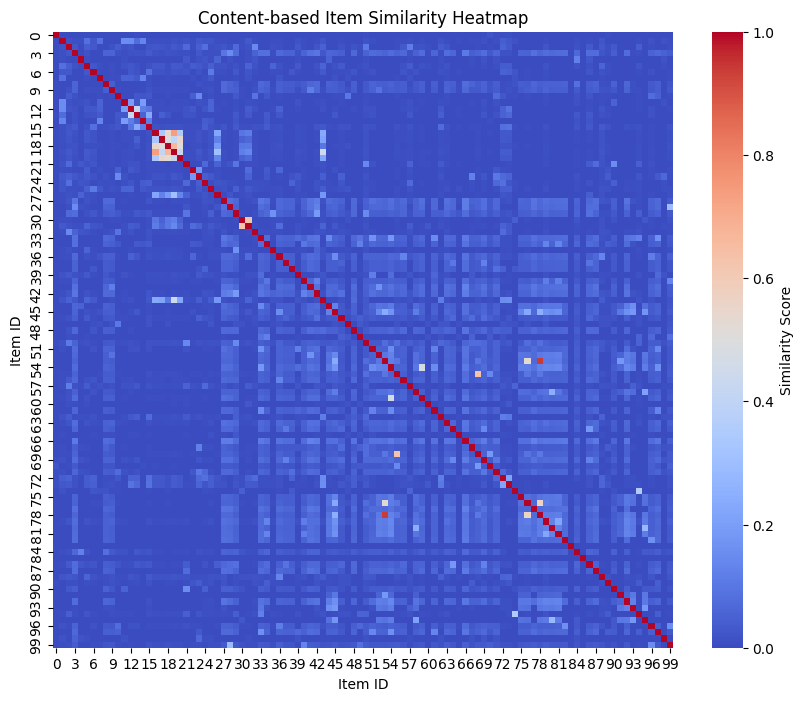

In [47]:
plot_similarity_heatmap(content_similarity, n_items=100, title="Content-based Item Similarity Heatmap",x_label='Item ID',y_label='Item ID')

In [48]:
items_old_df[(items_df['i']==53) | (items_old_df['i']==78)]

,Title,Author,ISBN Valid,Publisher,Subjects,i,content,content2
53,Fullmetal alchemist /,"Arakawa, Hiromu, 1973-",9782351420171; 2351420179; 9782351420188; 2351...,Kurokawa,Shônen; Mangas; Bandes dessinées,53,Fullmetal alchemist / Shônen; Mangas; Bandes d...,"Shônen; Mangas; Bandes dessinées Arakawa, Hiro..."
78,Fullmetal alchemist /,"Arakawa, Hiromu, 1973-",9782351427552; 2351427556; 9782351427521; 2351...,Kurokawa,Bandes dessinées; Mangas,78,Fullmetal alchemist / Bandes dessinées; Mangas...,"Bandes dessinées; Mangas Arakawa, Hiromu, 1973..."


In [49]:
content_similarity[53, 78]

0.9412720152120567

In [50]:
content_based_predictions1 = item_based_predict(train_data_matrix2, content_similarity)
print("Predicted Interaction Matrix using Content-based Similarity")
print(content_based_predictions1)

Predicted Interaction Matrix using Content-based Similarity
[[3.27977602e-02 8.19629266e-03 4.21569855e-03 ... 0.00000000e+00
  2.66373305e-03 1.99410577e-03]
 [0.00000000e+00 3.01971955e-04 8.76371505e-04 ... 0.00000000e+00
  5.24562799e-03 4.17240610e-04]
 [1.62228053e-03 1.04076254e-03 2.10997890e-03 ... 1.37015780e-01
  1.02910168e-01 1.61303686e-03]
 ...
 [0.00000000e+00 1.85364257e-05 5.12332889e-05 ... 1.62030339e-03
  6.55209884e-04 4.78181206e-05]
 [0.00000000e+00 4.46226693e-05 7.41613431e-05 ... 1.71623017e-03
  1.29724169e-03 6.92178099e-05]
 [0.00000000e+00 1.00890540e-04 8.68229373e-05 ... 0.00000000e+00
  7.20568572e-04 2.31528031e-04]]


In [51]:
content_based_predictions2 = item_based_predict(train_data_matrix2,content_similarity2)

In [52]:
precision_content_k, recall_content_k, map_content_k = precision_recall_at_k(content_based_predictions1, test_data_matrix, k=10)
print(f'Content-based CF Precision@K for k=10: {precision_content_k} Recall@K: {recall_content_k} MAP@K: {map_content_k}') 
precision_content_k2, recall_content_k2, map_content_k2 = precision_recall_at_k(content_based_predictions2, test_data_matrix, k=10)
print(f'Content-based CF Precision@K for k=10: {precision_content_k2} Recall@K: {recall_content_k2} MAP@K: {map_content_k2}')   

Content-based CF Precision@K for k=10: 0.03739474355702976 Recall@K: 0.21133210195661337 MAP@K: 0.04831115791345051
Content-based CF Precision@K for k=10: 0.032750701709618815 Recall@K: 0.18684089481300983 MAP@K: 0.042436736740711425


In [53]:
model4_1_predictions = item_based_predict(full_data_matrix2,content_similarity)

In [54]:
recommendations_df5 = create_recommendations_csv(model4_1_predictions, name='content_based_recommendations.csv')

Recommendations CSV created successfully.


## Fourth Model with more complete data

In [55]:
from sklearn.feature_extraction.text import TfidfVectorizer

items_df['content'] = items_df['Title'].fillna('') + ' ' + items_df['Subjects'].fillna('') + ' ' + items_df['Author'].fillna('') + ' ' + items_df['Publisher'].fillna('')
# Initialize the TF-IDF Vectorizer
tfidf = TfidfVectorizer(stop_words=None)
tfidf_matrix3 = tfidf.fit_transform(items_df['content'])
content_similarity3 = cosine_similarity(tfidf_matrix3)
content_based_predictions3 = item_based_predict(train_data_matrix2, content_similarity3)

print("Predicted Interaction Matrix using Content-based Similarity")
print(content_based_predictions3)

precision_content_k3, recall_content_k3, map_content_k3 = precision_recall_at_k(content_based_predictions3, test_data_matrix, k=10)
print(f'Content-based CF Precision@K for k=10: {precision_content_k3} Recall@K: {recall_content_k3} MAP@K: {map_content_k3}') 
  

Predicted Interaction Matrix using Content-based Similarity
[[2.78256472e-02 8.38449305e-03 5.31256146e-03 ... 0.00000000e+00
  2.66514243e-03 1.97006495e-03]
 [0.00000000e+00 3.09964237e-04 8.84203290e-04 ... 0.00000000e+00
  5.26717138e-03 4.25994106e-04]
 [1.23554431e-03 1.06767061e-03 2.12506587e-03 ... 1.38182940e-01
  1.03066682e-01 1.63219629e-03]
 ...
 [0.00000000e+00 1.90890036e-05 5.18956847e-05 ... 1.65939130e-03
  6.66043002e-04 4.90240139e-05]
 [0.00000000e+00 4.56140125e-05 7.44948574e-05 ... 1.72867571e-03
  1.29714178e-03 7.03726514e-05]
 [0.00000000e+00 1.03152715e-04 8.73401084e-05 ... 0.00000000e+00
  7.23096391e-04 2.36236342e-04]]
Content-based CF Precision@K for k=10: 0.04114570043378479 Recall@K: 0.23426266281915264 MAP@K: 0.0500012684624097


In [56]:
model4_2_predictions=item_based_predict(full_data_matrix2,content_similarity3)
recommendations_df6 = create_recommendations_csv(model4_2_predictions, name='content_based_recommendations2.csv')

Recommendations CSV created successfully.


In [57]:
def save_item_to_item_recommendations(similarity_matrix, filename='item_to_item_recommendations.csv', top_n=10):
    recommendations = []
    n_items = similarity_matrix.shape[0]
    for item_id in range(n_items):
        # Exclude self-similarity by setting it to -inf
        sim_scores = similarity_matrix[item_id].copy()
        sim_scores[item_id] = -np.inf
        # Get indices of top-N similar items
        top_items = np.argsort(sim_scores)[-top_n:][::-1]
        top_items_str = " ".join(map(str, top_items))
        recommendations.append([item_id, top_items_str])
    df = pd.DataFrame(recommendations, columns=['item_id', 'recommendation'])
    os.makedirs('recommendations', exist_ok=True)
    df.to_csv(os.path.join('recommendations',filename), index=False)
    print(f"Saved item-to-item recommendations to {filename}")

In [58]:
save_item_to_item_recommendations(item_similarity, filename='item_to_item_recommendations.csv', top_n=10)

Saved item-to-item recommendations to item_to_item_recommendations.csv


## Fifth Model : Text Embeddings

In [74]:

from sentence_transformers import SentenceTransformer
from sentence_transformers import InputExample, SentenceTransformer, losses, models
from torch.utils.data import DataLoader

sentence_model = SentenceTransformer("all-mpnet-base-v2")

# Generate embeddings for all items
items_df['embedding'] = list(sentence_model.encode(items_df['content'].tolist(), show_progress_bar=True))

embeddings_matrix = np.vstack(items_df['embedding'].values)
item_embedding_similarity = cosine_similarity(embeddings_matrix, embeddings_matrix)
print(item_embedding_similarity)
embedding_based_predictions = item_based_predict(full_data_matrix, item_embedding_similarity)
precision, recall, map_k = precision_recall_at_k(embedding_based_predictions, test_data_matrix, k=10)
print(f"Embedding-based Precision@10: {precision:.4f}, Recall@10: {recall:.4f}, MAP@10: {map_k:.4f}")

2025-05-23 14:32:57.014769: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Batches:   0%|          | 0/478 [00:00<?, ?it/s]

KeyboardInterrupt: 

## Last Model: Hybridization

### Hybrid recommendations with user & content

#### Graph to find the best weight

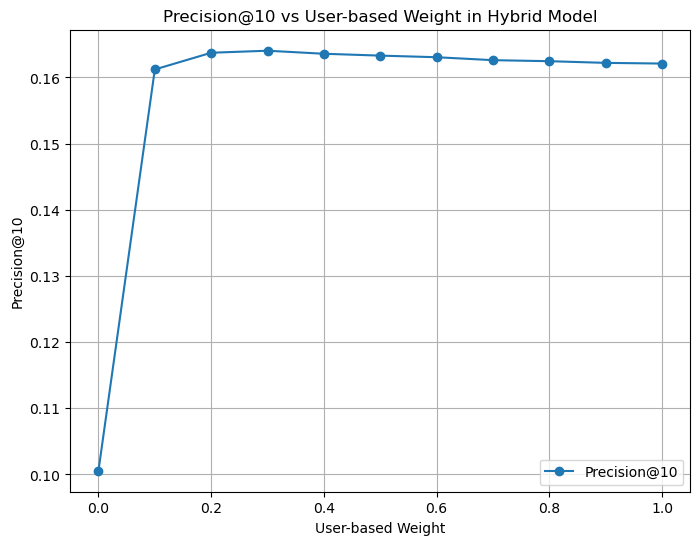

Best Precision@10: 0.1640 at user-based weight: 0.30


In [ ]:
'''
weights = np.arange(0, 1.05, 0.1)  # from 0 to 1, step 0.1
precisions = []

for w in weights:
    hybrid_pred = user_based_predictions2 * w + content_based_predictions * (1 - w)
    precision, _, _ = precision_recall_at_k(hybrid_pred, test_data_matrix, k=10)
    precisions.append(precision)

plt.figure(figsize=(8, 6))
plt.plot(weights, precisions, marker='o', label='Precision@10')
plt.xlabel('User-based Weight')
plt.ylabel('Precision@10')
plt.title('Precision@10 vs User-based Weight in Hybrid Model')
plt.legend()
plt.grid(True)
plt.show()

best_idx = np.argmax(precisions)
print(f'Best Precision@10: {precisions[best_idx]:.4f} at user-based weight: {weights[best_idx]:.2f}')
'''

In [59]:
hybrid_predictions1 = user_based_predictions2*0.3 + content_based_predictions3*0.7
print(precision_recall_at_k(hybrid_predictions1, test_data_matrix, k=10))

(0.05782087267160297, 0.2930227974387152, 0.057976528923025274)


In [ ]:
model6_predictions = moddel3_2_predictions*0.3 + model4_2_predictions*0.7

(0.1635238581270705, 0.8818506192729195, 0.17445959121600535)


In [61]:
hybrid_recommendations_df1 = create_recommendations_csv(model6_predictions, name='hybrid_recommendation1.csv')

Recommendations CSV created successfully.


### Hybrid recommendations with user & item

#### Graph to find the best weight

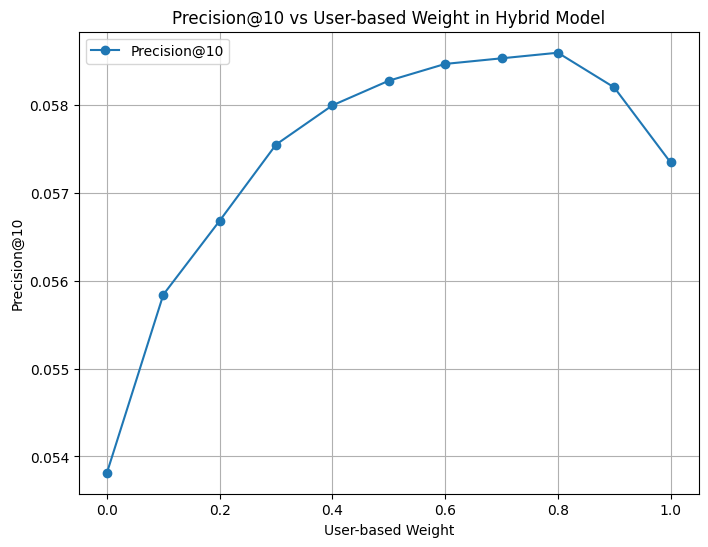

Best Precision@10: 0.0586 at user-based weight: 0.80


In [63]:

weights = np.arange(0, 1.05, 0.1)  # from 0 to 1, step 0.1
precisions = []

for w in weights:
    hybrid_pred = user_based_predictions2 * w + item_based_predictions2 * (1 - w)
    precision, _, _ = precision_recall_at_k(hybrid_pred, test_data_matrix, k=10)
    precisions.append(precision)

plt.figure(figsize=(8, 6))
plt.plot(weights, precisions, marker='o', label='Precision@10')
plt.xlabel('User-based Weight')
plt.ylabel('Precision@10')
plt.title('Precision@10 vs User-based Weight in Hybrid Model')
plt.legend()
plt.grid(True)
plt.show()

best_idx = np.argmax(precisions)
print(f'Best Precision@10: {precisions[best_idx]:.4f} at user-based weight: {weights[best_idx]:.2f}')

#### Hybrid model

In [64]:
hybrid_predictions2 = user_based_predictions2*0.8 + item_based_predictions2*0.2
print(precision_recall_at_k(hybrid_predictions2, test_data_matrix, k=10))

(0.05859913243174593, 0.2926331121337966, 0.05747404611434035)


In [ ]:
model6_predictions2 = moddel3_2_predictions*0.8 + model3_1_predictions*0.2

(0.1679382495534536, 0.8959064070877688, 0.17917418572736493)


In [66]:
hybrid_recommendations_df2 = create_recommendations_csv(hybrid_predictions2, name='hybrid_recommendation2.csv')

Recommendations CSV created successfully.


### Hybrid recommendation with user, item & content

#### Graph to find best weights

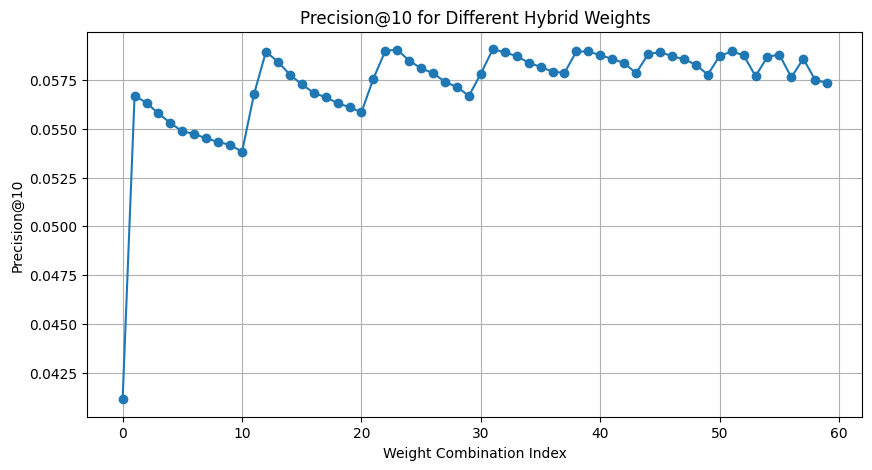

Best Precision@10: 0.0591 at weights user=0.30, item=0.10, content=0.60


In [67]:

weight_range = np.arange(0, 1.01, 0.1)
precisions = []
weights_list = []

for w1 in weight_range:
    for w2 in weight_range:
        w3 = 1.0 - w1 - w2
        if w3 < 0 or w3 > 1:
            continue
        hybrid_pred = user_based_predictions2 * w1 + item_based_predictions2 * w2 + content_based_predictions3 * w3
        precision, _, _ = precision_recall_at_k(hybrid_pred, test_data_matrix, k=10)
        precisions.append(precision)
        weights_list.append((w1, w2, w3))

# Plot
plt.figure(figsize=(10, 5))
plt.plot(range(len(precisions)), precisions, marker='o')
plt.xlabel('Weight Combination Index')
plt.ylabel('Precision@10')
plt.title('Precision@10 for Different Hybrid Weights')
plt.grid(True)
plt.show()

# Print the best weights
best_idx = np.argmax(precisions)
best_weights = weights_list[best_idx]
print(f'Best Precision@10: {precisions[best_idx]:.4f} at weights user={best_weights[0]:.2f}, item={best_weights[1]:.2f}, content={best_weights[2]:.2f}')


#### Hybrid Model

In [68]:
hybrid_predictions3 = user_based_predictions2*0.3 + item_based_predictions2*0.1 + content_based_predictions3*0.6
print(precision_recall_at_k(hybrid_predictions3, test_data_matrix, k=10))

(0.059071191630521214, 0.2954689624408209, 0.05824200739499396)


In [71]:
model6_predictions3 = moddel3_2_predictions*0.3   + model3_1_predictions*0.1 + model4_2_predictions*0.6
print(precision_recall_at_k(model6_predictions3, test_data_matrix, k=10))

(0.1691375350854762, 0.9006292376520751, 0.17952054708597676)


In [73]:
hybrid_recommendations_df3 = create_recommendations_csv(model6_predictions3, name='hybrid_recommendations3.csv')

Recommendations CSV created successfully.


### Hybrid recommendation with embedding

#### Graph to find the best weights

In [92]:
'''
weight_range = np.arange(0, 1.05, 0.1)
best_precision = 0
best_weights = (0, 0, 0, 0)
precisions = []
weights_list = []

for w1 in weight_range:
    for w2 in weight_range:
        for w3 in weight_range:
            w4 = 1.0 - w1 - w2 - w3
            if w4 < 0 or w4 > 1:
                continue
            # Hybrid prediction: user, item, content, embedding
            hybrid_pred = (
                user_based_predictions2 * w1 +
                item_based_predictions * w2 +
                content_based_predictions * w3 +
                embedding_based_predictions * w4
            )
            precision, _, _ = precision_recall_at_k(hybrid_pred, test_data_matrix, k=10)
            precisions.append(precision)
            weights_list.append((w1, w2, w3, w4))
            if precision > best_precision:
                best_precision = precision
                best_weights = (w1, w2, w3, w4)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(range(len(precisions)), precisions, marker='o')
plt.xlabel('Weight Combination Index')
plt.ylabel('Precision@10')
plt.title('Precision@10 for Different Hybrid Weights (User, Item, Content, Embedding)')
plt.grid(True)
plt.show()

print(f'Best Precision@10: {best_precision:.4f} at weights user={best_weights[0]:.2f}, item={best_weights[1]:.2f}, content={best_weights[2]:.2f}, embedding={best_weights[3]:.2f}')
'''

"\nweight_range = np.arange(0, 1.05, 0.1)\nbest_precision = 0\nbest_weights = (0, 0, 0, 0)\nprecisions = []\nweights_list = []\n\nfor w1 in weight_range:\n    for w2 in weight_range:\n        for w3 in weight_range:\n            w4 = 1.0 - w1 - w2 - w3\n            if w4 < 0 or w4 > 1:\n                continue\n            # Hybrid prediction: user, item, content, embedding\n            hybrid_pred = (\n                user_based_predictions2 * w1 +\n                item_based_predictions * w2 +\n                content_based_predictions * w3 +\n                embedding_based_predictions * w4\n            )\n            precision, _, _ = precision_recall_at_k(hybrid_pred, test_data_matrix, k=10)\n            precisions.append(precision)\n            weights_list.append((w1, w2, w3, w4))\n            if precision > best_precision:\n                best_precision = precision\n                best_weights = (w1, w2, w3, w4)\n\n# Plot\nplt.figure(figsize=(12, 6))\nplt.plot(range(len(prec

In [93]:
hybrid_predictions4 = user_based_predictions2*0.1 + item_based_predictions * 0.2 + content_based_predictions * 0.4 + embedding_based_predictions*0.3
print(precision_recall_at_k(hybrid_predictions4, test_data_matrix, k=10))

(0.17089818831333975, 0.9101317588599334, 0.18040529038488154)


In [94]:
hybrid_recommendations_df4 = create_recommendations_csv(hybrid_predictions4, name='hybrid_recommendation4.csv')

Recommendations CSV created successfully.
